In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
dirs = ['baseline-no-prefetch', 'prefetch-64KB', 'adaptive-prefetch']

In [ ]:
data = []
for d in dirs:
    for file in os.listdir(d):
        if file.startswith('output_') and file.endswith('.log'):
            scene_name = file[len('output_'):-len('.log')]
            with open(os.path.join(d, file), 'r') as f:
                content = f.readlines()
            ipc = None
            instructions = None
            l1d_misses = None
            prefetch_effectiveness = {}
            for line in content:
                if 'gpu_tot_ipc' in line:
                    ipc = float(line.split('=')[1].strip())
                elif 'gpu_tot_sim_insn' in line:
                    instructions = int(line.split('=')[1].strip())
                elif 'L1D_total_cache_misses' in line:
                    l1d_misses = int(line.split('=')[1].strip())
                elif 'Prefetch Effectiveness per cluster' in line:
                    # Read next 5 lines for effectiveness data
                    # Read from content list variable instead of reopening file
                    line_index = content.index(line)
                    f = iter(content[line_index + 1:])
                    effectiveness_lines = [next(f).strip() for _ in range(5)]
                    labels = ['Too Late', 'Late', 'Timely', 'Early', 'Unused']
                    for label, eff_line in zip(labels, effectiveness_lines):
                        total_sum = int(eff_line.split()[-1])
                        prefetch_effectiveness[label] = total_sum
            data.append({
                'Directory': d,
                'Scene': scene_name,
                'IPC': ipc,
                'Instructions': instructions,
                'L1D Misses': l1d_misses,
                **prefetch_effectiveness
            })
df = pd.DataFrame(data)
df = df.dropna()

In [19]:
df

,Directory,Scene,IPC,Instructions,L1D Misses,Too Late,Late,Timely,Early,Unused
0,baseline-no-prefetch,LANDS,5.4702,1825883.0,91870.0,0.0,0.0,0.0,0.0,0.0
1,baseline-no-prefetch,PARTY,3.9248,2066661.0,110296.0,0.0,0.0,0.0,0.0,0.0
2,baseline-no-prefetch,FRST,4.7589,1569528.0,97089.0,0.0,0.0,0.0,0.0,0.0
3,baseline-no-prefetch,FOX,1.6424,1624054.0,230875.0,0.0,0.0,0.0,0.0,0.0
4,baseline-no-prefetch,PARK,1.1772,1881707.0,507667.0,0.0,0.0,0.0,0.0,0.0
5,baseline-no-prefetch,ROBOT,1.2551,2809552.0,744898.0,0.0,0.0,0.0,0.0,0.0
6,prefetch-64KB,LANDS,8.7879,1825883.0,108205.0,281.0,4222.0,4771.0,116.0,40561.0
7,prefetch-64KB,PARTY,6.3687,2066661.0,137424.0,1209.0,9603.0,13100.0,92.0,54902.0
8,prefetch-64KB,FRST,6.3261,1569528.0,122611.0,577.0,7380.0,7557.0,124.0,48723.0
9,prefetch-64KB,FOX,2.3286,1624054.0,288644.0,807.0,20241.0,22222.0,624.0,100246.0


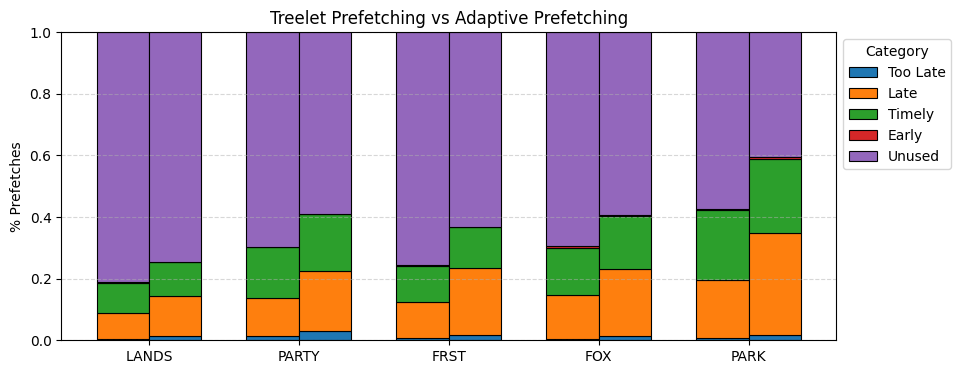

In [ ]:
prefetch_df = df[df["Directory"].isin(["prefetch-64KB", "adaptive-prefetch"])].copy()

cols = ["Too Late", "Late", "Timely", "Early", "Unused"]
prefetch_df[cols] = prefetch_df[cols].div(prefetch_df[cols].sum(axis=1), axis=0)

scenes = prefetch_df["Scene"].unique()
configs = ["prefetch-64KB", "adaptive-prefetch"]
x = np.arange(len(scenes))
bar_width = 0.35

colors = {
    "Too Late": "#1F77B3",
    "Late": "#FE7F0E",
    "Timely": "#2C9F2C",
    "Early": "#D52728",
    "Unused": "#9367BC"
}

fig, ax = plt.subplots(figsize=(10, 4))

for i, config in enumerate(configs):
    subset = prefetch_df[prefetch_df["Directory"] == config]
    bottom = np.zeros(len(subset))
    for label in cols:
        ax.bar(
            x + i * bar_width - bar_width / 2,
            subset[label],
            width=bar_width,
            bottom=bottom,
            label=label if i == 0 else None,  # add legend only once
            color=colors[label],
            edgecolor='black',
            linewidth=0.8
        )
        bottom += subset[label].values

ax.set_ylabel("% Prefetches")
ax.set_title("Treelet Prefetching vs Adaptive Prefetching")
ax.set_xticks(x)
ax.set_xticklabels(scenes)
ax.legend(title="Category", loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0, 1.0)
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

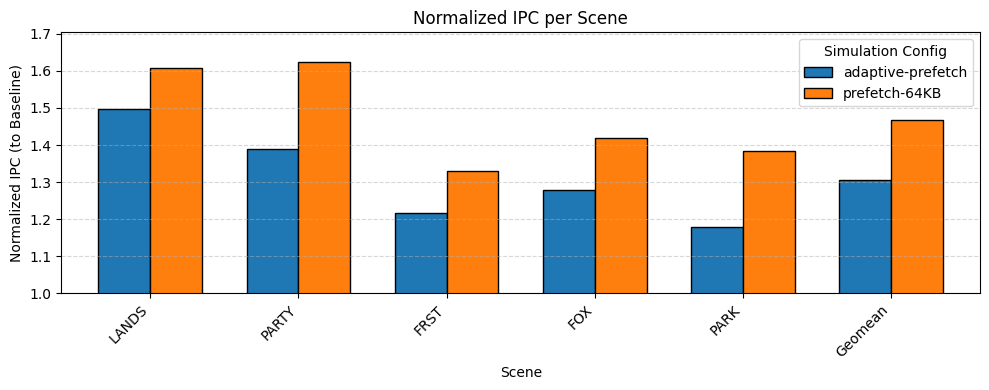

In [ ]:
baseline_df = df[df['Directory'] == 'baseline-no-prefetch'][['Scene', 'IPC']].set_index('Scene')
norm_ipc_df = df[df['Directory'].isin(['prefetch-64KB', 'adaptive-prefetch'])].copy()
norm_ipc_df['Baseline IPC'] = norm_ipc_df['Scene'].map(baseline_df['IPC'])
norm_ipc_df['Normalized IPC'] = norm_ipc_df['IPC'] / norm_ipc_df['Baseline IPC']

ipc_pivot = norm_ipc_df.pivot(index='Scene', columns='Directory', values='Normalized IPC')
ipc_pivot = ipc_pivot.loc[scenes]  # keep scene order consistent

geo_mean = ipc_pivot.apply(lambda x: np.exp(np.log(x).mean()), axis=0)
geo_mean.name = 'Geomean'

ipc_pivot = pd.concat([ipc_pivot, geo_mean.to_frame().T])

fig, ax = plt.subplots(figsize=(10, 4))
ipc_pivot.plot(kind='bar', ax=ax, width=0.7, edgecolor='black')

ax.set_ylabel('Normalized IPC (to Baseline)')
ax.set_xlabel('Scene')
ax.set_title('Normalized IPC per Scene')
ax.set_xticklabels(ipc_pivot.index, rotation=45, ha='right')
ax.legend(title='Simulation Config')
ax.set_ylim(bottom=1)
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()